### Imports

In [1]:
import numpy as np
import pandas as pd
import math
import requests
from numpy import nan
import re
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

### File reading

In [2]:
data = pd.read_csv('./raw_dataset_houses.csv', index_col = 0)
data = data.drop(['Dostępne od', 'Media', 'Obsługa zdalna', 'Typ ogłoszeniodawcy', 'Materiał budynku', 'Ilość pokoi', 'Dach', 'Pokrycie dachu', 'Położenie', 'Dojazd', 'Poddasze', 'Okna'], axis = 1)

In [3]:
data.rename(columns = {'Cena': 'price', 'Cena za metr kwadratowy': 'price_per_square_meter', 'Powierzchnia': 'area', 'Lokalizacja': 'location', 'Liczba pokoi': 'number_of_rooms', 'Stan wykończenia': 'finishing_standard', 'Liczba pięter': 'number_of_floors', 'Czynsz': 'rent', 'Miejsce parkingowe': 'parking', 'Ogrzewanie': 'heating', 'Rynek': 'market', 'Rok budowy': 'construction_year', 'Rodzaj zabudowy': 'building_type', 'Winda': 'lift', 'Zabezpieczenia': 'security', 'Informacje dodatkowe': 'additional_information', 'Dom rekreacyjny': 'summer_house', 'Ogrodzenie': 'fence', 'Okolica': 'surroundings', 'Powierzchnia działki': 'land_area'}, inplace=True)

In [4]:
data = data.reset_index(drop = True)

In [5]:
data.head()

,price,price_per_square_meter,area,location,heating,land_area,finishing_standard,building_type,construction_year,number_of_rooms,parking,rent,market,windows,number_of_floors,summer_house,security,fence,surroundings,additional_information
0,80 000 zł,1143 zł/m2,70 m²,"Piszewo, warmińsko-mazurskie",Zapytaj,806 m²,do remontu,wolnostojący,1930,3,Zapytaj,Zapytaj,wtórny,brak informacji,1 piętro,brak informacji,brak informacji,siatka,brak informacji,brak informacji
1,369 000 zł,858 zł/m2,430 m²,"Dworcowa, Grabów, łódzkie",Zapytaj,7400 m²,do remontu,Zapytaj,Zapytaj,9,Zapytaj,Zapytaj,wtórny,brak informacji,brak informacji,brak informacji,brak informacji,brak informacji,brak informacji,brak informacji
2,800 000 zł,2000 zł/m2,400 m²,"Mońki, moniecki, podlaskie",olejowe,1500 m²,do zamieszkania,wolnostojący,1982,7,Zapytaj,Zapytaj,wtórny,plastikowe,2 piętra,brak informacji,brak informacji,inne,brak informacji,brak informacji
3,849 600 zł,1770 zł/m2,480 m²,"Mrągowo, warmińsko-mazurskie",biomasa,2300 m²,do zamieszkania,wolnostojący,Zapytaj,więcej niż 10,garaż,Zapytaj,wtórny,plastikowe,brak informacji,brak informacji,"drzwi / okna antywłamaniowe, rolety antywłaman...","murowane, metalowe, siatka","las, jezioro","strych, piwnica"
4,395 000 zł,3292 zł/m2,120 m²,"Brzesko, brzeski, małopolskie",Zapytaj,300 m²,do remontu,Zapytaj,Zapytaj,3,garaż,Zapytaj,wtórny,brak informacji,1 piętro,brak informacji,brak informacji,brak informacji,brak informacji,brak informacji


In [6]:
data.describe()

,price,price_per_square_meter,area,location,heating,land_area,finishing_standard,building_type,construction_year,number_of_rooms,parking,rent,market,windows,number_of_floors,summer_house,security,fence,surroundings,additional_information
count,47651,46963,47651,47651,47598,47598,47598,47598,47598,47598,47598,47598,46979,46979,46979,46979,46979,46979,46979,46979
unique,3136,9952,7654,19690,168,5366,6,9,241,11,2,124,2,5,5,2,64,106,14,30
top,699 000 zł,5000 zł/m2,120 m²,"Grodzisk Mazowiecki, mazowieckie",Zapytaj,Zapytaj,do zamieszkania,wolnostojący,2022,4,garaż,Zapytaj,wtórny,plastikowe,1 piętro,brak informacji,brak informacji,brak informacji,brak informacji,brak informacji
freq,754,290,1091,261,19962,2153,16817,24246,10407,14471,27851,46762,31775,27725,23525,46454,30372,25575,35030,33664


In [7]:
def get_address_details(location):
    location = re.sub(r'\w*\.\w*', '', location).strip()
    r = requests.get(f'https://nominatim.openstreetmap.org/search/{location}?format=json&addressdetails=1')
    if(bool(r.json())):
        result = r.json()[0]
        address_details = result['address']
        return {'latitude': result['lat'], 'longtitude': result['lon'], 'city': address_details.get('city', nan), 'state': address_details.get('state', nan), 'village': address_details.get('village', nan), 'town': address_details.get('town', nan), 'road': address_details.get('road', nan), 'city_district': address_details.get('city_district', nan)}


def get_population(locality):
    r = requests.get(f'https://public.opendatasoft.com/api/records/1.0/search/?dataset=geonames-all-cities-with-a-population-1000&q={locality}')
    if(locality.lower() == 'Warszawa'.lower()):
        return 1765000
    if(bool(r.json().get('records'))):
        return r.json().get('records')[0].get('fields').get('population')

In [8]:
def get_time_to_nearest_point(point_type, lat, lon):
    result = requests.get(f'https://nominatim.openstreetmap.org/search.php?q={point_type}+near+{lat},{lon}&format=jsonv2&limit=1').json()
    if(bool(result)):
        point_lat = result[0].get('lat')
        point_lon = result[0].get('lon')
        duration_res = requests.get(f'https://router.project-osrm.org/route/v1/car/{lon},{lat};{point_lon},{point_lat}?overview=false').json()
        if(bool(duration_res and bool(duration_res.get('routes')))):
            duration = duration_res.get('routes')[0].get('duration') 
            return duration / 60 #convert to minutes

def get_time_to_nearest_shop(lat, lon):
    time_to_nearest_supermarket = get_time_to_nearest_point('supermarket', lat, lon)
    time_to_nearest_convenience_shop = get_time_to_nearest_point('convenience_shop', lat, lon)
    
    result = min(time_to_nearest_supermarket or 100000, time_to_nearest_convenience_shop or 100000)
    
    if(result != 100000):
        return result

def get_time_to_nearest_stop(lat, lon):
    time_to_nearest_bus_stop = get_time_to_nearest_point('bus stop', lat, lon)
    time_to_nearest_tram_stop = get_time_to_nearest_point('tram stop', lat, lon)
    
    result = min(time_to_nearest_bus_stop or 100000, time_to_nearest_tram_stop or 100000) 
    
    if(result != 100000):
        return result

def get_time_to_centre(lat, lon, location):
    result = requests.get(f'https://nominatim.openstreetmap.org/search/{location}?format=json&addressdetails=1').json()
    if(bool(result)):
        centre_lat = result[0].get('lat')
        centre_lon = result[0].get('lon')
        duration_res = requests.get(f'https://router.project-osrm.org/route/v1/car/{lon},{lat};{centre_lon},{centre_lat}?overview=false').json()
        if(bool(duration_res) and bool(duration_res.get('routes'))):
            duration = duration_res.get('routes')[0].get('duration')  
            return duration / 60 #convert to minutes

In [9]:
data = data.fillna(nan)
data = data.replace({'zapytaj': nan, "Zapytaj o cenę": nan, "brak informacji": nan})

In [10]:
for index, row in data.iterrows():
    if(index > 0):
        break
    if(data.loc[index, 'price'] is nan or (data.loc[index, 'price'] is not nan and '€' in data.loc[index, 'price'])):
        data = data.drop(index)

In [11]:
data = data.reset_index(drop = True)

In [ ]:
for index, row in data.iterrows():
    if(index > 24176):
        print(index)
        row = row.copy()
        location = row.location 
        dict_temp = get_address_details(location)
        if(bool(dict_temp)):
            data.loc[index, 'state'] = dict_temp.get('state')

            if(isinstance(dict_temp.get('city'), str)):
                data.loc[index, 'locality'] = dict_temp.get('city')
                data.loc[index, 'population'] = get_population(dict_temp.get('city'))
                data.loc[index, 'type_of_locality'] = 'city'
            if(isinstance(dict_temp.get('village'), str)):
                data.loc[index, 'locality'] = dict_temp.get('village')
                data.loc[index, 'population'] = get_population(dict_temp.get('village'))
                data.loc[index, 'type_of_locality'] = 'village'
            if(isinstance(dict_temp.get('town'), str)):
                data.loc[index, 'locality'] = dict_temp.get('town')
                data.loc[index, 'population'] = get_population(dict_temp.get('town'))
                data.loc[index, 'type_of_locality'] = 'town'

            latitude = dict_temp.get('latitude')
            longtitude = dict_temp.get('longtitude')
            locality = data.iloc[index]['locality']
            data.loc[index, 'time_to_nearest_shop'] = get_time_to_nearest_shop(latitude, longtitude)
            data.loc[index, 'time_to_nearest_stop'] = get_time_to_nearest_stop(latitude, longtitude)
            data.loc[index, 'time_to_centre'] = get_time_to_centre(latitude, longtitude, locality)

24177
24178
24179
24180
24181
24182
24183
24184
24185
24186
24187
24188
24189
24190
24191
24192
24193
24194
24195
24196
24197
24198
24199
24200
24201
24202
24203
24204
24205
24206
24207
24208
24209
24210
24211
24212
24213
24214
24215
24216
24217
24218
24219
24220
24221
24222
24223
24224
24225
24226
24227
24228
24229
24230
24231
24232
24233
24234
24235
24236
24237
24238
24239
24240
24241
24242
24243
24244
24245
24246
24247
24248
24249
24250
24251
24252
24253
24254
24255
24256
24257
24258
24259
24260
24261
24262
24263
24264
24265
24266
24267
24268
24269
24270
24271
24272
24273
24274
24275
24276
24277
24278
24279
24280
24281
24282
24283
24284
24285
24286
24287
24288
24289
24290
24291
24292
24293
24294
24295
24296
24297
24298
24299
24300
24301
24302
24303
24304
24305
24306
24307
24308
24309
24310
24311
24312
24313
24314
24315
24316
24317
24318
24319
24320
24321
24322
24323
24324
24325
24326
24327
24328
24329
24330
24331
24332
24333
24334
24335
24336
24337
24338
24339
24340
24341
24342
2434

25543
25544
25545
25546
25547
25548
25549
25550
25551
25552
25553
25554
25555
25556
25557
25558
25559
25560
25561
25562
25563
25564
25565
25566
25567
25568
25569
25570
25571
25572
25573
25574
25575
25576
25577
25578
25579
25580
25581
25582
25583
25584
25585
25586
25587
25588
25589
25590
25591
25592
25593
25594
25595
25596
25597
25598
25599
25600
25601
25602
25603
25604
25605
25606
25607
25608
25609
25610
25611
25612
25613
25614
25615
25616
25617
25618
25619
25620
25621
25622
25623
25624
25625
25626
25627
25628
25629
25630
25631
25632
25633
25634
25635
25636
25637
25638
25639
25640
25641
25642
25643
25644
25645
25646
25647
25648
25649
25650
25651
25652
25653
25654
25655
25656
25657
25658
25659
25660
25661
25662
25663
25664
25665
25666
25667
25668
25669
25670
25671
25672
25673
25674
25675
25676
25677
25678
25679
25680
25681
25682
25683
25684
25685
25686
25687
25688
25689
25690
25691
25692
25693
25694
25695
25696
25697
25698
25699
25700
25701
25702
25703
25704
25705
25706
25707
25708
2570

In [27]:
data.to_csv('./enriched_dataset_houses.csv')

In [22]:
data = data.fillna(nan)

In [23]:
data.to_csv('./enriched_dataset_houses.csv')

In [16]:
data = pd.read_csv('./enriched_dataset_houses.csv', index_col = 0)
data.head()

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,security,furnishings,additional_information,state,locality,population,type_of_locality,time_to_nearest_shop,time_to_nearest_stop,time_to_centre
0,560 000 zł,9887 zł/m2,"56,64 m²","ul. Brylantowa, Dobrzykowice, dolnośląskie",3,do zamieszkania,1/3,balkon,600 zł,garaż/miejsce parkingowe,...,"drzwi / okna antywłamaniowe, domofon / wideofon","zmywarka, lodówka, meble, piekarnik, kuchenka,...",NaN,województwo dolnośląskie,Dobrzykowice,NaN,village,5.045000,3.238333,3.256667
1,950 000 zł,14 175 zł/m2,"67,02 m²","Warszawa, Praga-Południe, ul. Terespolska",3,do zamieszkania,6/6,balkon,610 zł,garaż/miejsce parkingowe,...,"teren zamknięty, domofon / wideofon, monitorin...","zmywarka, lodówka, meble, piekarnik, kuchenka,...",oddzielna kuchnia,województwo mazowieckie,Warszawa,1765000.0,city,0.220000,0.246667,9.410000
2,264 900 zł,9811 zł/m2,27 m²,"Katowice, Piotrowice - Ochojec, Ochojec",1,do zamieszkania,5/8,balkon,NaN,NaN,...,monitoring / ochrona,NaN,NaN,województwo śląskie,Katowice,317316.0,city,1.901667,0.180000,12.275000
3,464 000 zł,8000 zł/m2,58 m²,"Sosnowiec, Zagórze",3,do zamieszkania,2/3,balkon,350 zł,garaż/miejsce parkingowe,...,NaN,NaN,oddzielna kuchnia,województwo śląskie,Sosnowiec,227295.0,city,2.395000,3.275000,10.791667
4,199 900 zł,5666 zł/m2,"35,28 m²","Sosnowiec, Klimontów",2,do zamieszkania,4/4,balkon,420 zł,NaN,...,NaN,NaN,"piwnica, oddzielna kuchnia",województwo śląskie,Sosnowiec,227295.0,city,3.190000,1.856667,10.391667


In [25]:
data.columns

Index(['price', 'price_per_square_meter', 'area', 'location', 'heating',
       'land_area', 'finishing_standard', 'building_type', 'construction_year',
       'number_of_rooms', 'parking', 'rent', 'market', 'windows',
       'number_of_floors', 'summer_house', 'security', 'fence', 'surroundings',
       'additional_information', 'state', 'locality', 'population',
       'type_of_locality', 'time_to_nearest_shop', 'time_to_nearest_stop',
       'time_to_centre'],
      dtype='object')

### Categorical columns

In [17]:
categorical_columns_names = ['finishing_standard', 'parking', 'heating', 'market', 'building_type', 'security', 'furnishings', 'additional_information', 'summer_house', 'fence', 'surroundings']

In [18]:
for column_name in categorical_columns_names:
    print(column_name)
    print(data[column_name].unique())

finishing_standard
['do zamieszkania' 'do remontu' nan 'do wykończenia']
balcony/garden/terrace
['balkon' 'taras' nan 'ogródek' 'ogródek, taras' 'balkon, ogródek, taras'
 'balkon, taras' 'balkon, ogródek' 'taras, ogródek' 'taras, balkon'
 'taras, balkon, ogródek']
parking
['garaż/miejsce parkingowe' nan]
heating
['kotłownia' 'miejskie' 'gazowe' nan 'inne' 'elektryczne' 'piece kaflowe'
 'tak']
market
['wtórny' nan 'pierwotny']
building_type
['blok' 'apartamentowiec' nan 'kamienica' 'szeregowiec' 'dom wolnostojący'
 'plomba' 'loft' 'bliźniak']
windows
['plastikowe' nan 'drewniane' 'aluminiowe']
lift
['tak' 'nie' nan]
security
['drzwi / okna antywłamaniowe, domofon / wideofon'
 'teren zamknięty, domofon / wideofon, monitoring / ochrona'
 'monitoring / ochrona' nan
 'drzwi / okna antywłamaniowe, teren zamknięty, domofon / wideofon'
 'domofon / wideofon'
 'teren zamknięty, domofon / wideofon, monitoring / ochrona, rolety antywłamaniowe'
 'system alarmowy, teren zamknięty, domofon / wideofon

In [19]:
le_finishing_standard = preprocessing.LabelEncoder()
le_finishing_standard.fit(data['finishing_standard'])
print(list(le_finishing_standard.classes_))
data['finishing_standard'] = le_finishing_standard.fit_transform(data['finishing_standard'])

le_heating = preprocessing.LabelEncoder()
le_heating.fit(data['heating'])
print(list(le_heating.classes_))
data['heating'] = le_heating.fit_transform(data['heating'])

le_building_type = preprocessing.LabelEncoder()
le_building_type.fit(data['building_type'])
print(list(le_building_type.classes_))
data['building_type'] = le_building_type.fit_transform(data['building_type'])


le_market = preprocessing.LabelEncoder()
le_market.fit(data['market'])
print(list(le_market.classes_))
data['market'] = le_market.fit_transform(data['market'])

le_state = preprocessing.LabelEncoder()
le_state.fit(data['state'])
print(list(le_state.classes_))
data['state'] = le_state.fit_transform(data['state'])

le_locality = preprocessing.LabelEncoder()
le_locality.fit(data['locality'])
print(list(le_locality.classes_))
data['locality'] = le_locality.fit_transform(data['locality'])

le_locality_type = preprocessing.LabelEncoder()
le_locality_type.fit(data['type_of_locality'])
print(list(le_locality_type.classes_))
data['type_of_locality'] = le_locality_type.fit_transform(data['type_of_locality'])


['do remontu', 'do wykończenia', 'do zamieszkania', nan]
['elektryczne', 'gazowe', 'inne', 'kotłownia', 'miejskie', 'piece kaflowe', 'tak', nan]
['apartamentowiec', 'bliźniak', 'blok', 'dom wolnostojący', 'kamienica', 'loft', 'plomba', 'szeregowiec', nan]
['aluminiowe', 'drewniane', 'plastikowe', nan]
['pierwotny', 'wtórny', nan]
['Centre-Val de Loire', 'województwo dolnośląskie', 'województwo kujawsko-pomorskie', 'województwo lubelskie', 'województwo lubuskie', 'województwo mazowieckie', 'województwo małopolskie', 'województwo opolskie', 'województwo podkarpackie', 'województwo podlaskie', 'województwo pomorskie', 'województwo warmińsko-mazurskie', 'województwo wielkopolskie', 'województwo zachodniopomorskie', 'województwo łódzkie', 'województwo śląskie', 'województwo świętokrzyskie', nan]
['Adamowizna', 'Adamowo', 'Aleksandria', 'Aleksandrowo', 'Aleksandrów Kujawski', 'Aleksandrów Łódzki', 'Amandów', 'Andrychów', 'Augustów', 'Babia Ława', 'Babimost', 'Baborów', 'Badowo-Dańki', 'Bagna

In [20]:
data = data.assign(
    has_balkon = data['balcony/garden/terrace'].fillna('nan').apply(lambda x: ('balkon' in x)).astype(int),
    has_garden = data['balcony/garden/terrace'].fillna('nan').apply(lambda x: ('ogródek' in x)).astype(int),
    has_terrace = data['balcony/garden/terrace'].fillna('nan').apply(lambda x: ('taras' in x)).astype(int),
    has_parking = (~data.parking.isna()).astype(int),
    is_furnished = (~data.furnishings.isna()).astype(int),
    has_lift = (data.lift == 'tak').astype(int),
    has_security_protection = (~data.security.isna()).astype(int),
    is_duplex = data['additional_information'].fillna('nan').apply(lambda x: ('dwupoziomowe' in x)).astype(int),
    has_basement = data['additional_information'].fillna('nan').apply(lambda x: ('piwnica' in x)).astype(int))

In [21]:
data.head()

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,time_to_centre,has_balkon,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement
0,560 000 zł,9887 zł/m2,"56,64 m²","ul. Brylantowa, Dobrzykowice, dolnośląskie",3,2,1/3,balkon,600 zł,garaż/miejsce parkingowe,...,3.256667,1,0,0,1,1,1,1,0,0
1,950 000 zł,14 175 zł/m2,"67,02 m²","Warszawa, Praga-Południe, ul. Terespolska",3,2,6/6,balkon,610 zł,garaż/miejsce parkingowe,...,9.410000,1,0,0,1,1,1,1,0,0
2,264 900 zł,9811 zł/m2,27 m²,"Katowice, Piotrowice - Ochojec, Ochojec",1,2,5/8,balkon,NaN,NaN,...,12.275000,1,0,0,0,0,1,1,0,0
3,464 000 zł,8000 zł/m2,58 m²,"Sosnowiec, Zagórze",3,2,2/3,balkon,350 zł,garaż/miejsce parkingowe,...,10.791667,1,0,0,1,0,1,0,0,0
4,199 900 zł,5666 zł/m2,"35,28 m²","Sosnowiec, Klimontów",2,2,4/4,balkon,420 zł,NaN,...,10.391667,1,0,0,0,0,0,0,0,1


### Numerical columns

In [22]:
data = data[data['price'].str.contains("zł", na = False)]
data

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,time_to_centre,has_balkon,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement
0,560 000 zł,9887 zł/m2,"56,64 m²","ul. Brylantowa, Dobrzykowice, dolnośląskie",3,2,1/3,balkon,600 zł,garaż/miejsce parkingowe,...,3.256667,1,0,0,1,1,1,1,0,0
1,950 000 zł,14 175 zł/m2,"67,02 m²","Warszawa, Praga-Południe, ul. Terespolska",3,2,6/6,balkon,610 zł,garaż/miejsce parkingowe,...,9.410000,1,0,0,1,1,1,1,0,0
2,264 900 zł,9811 zł/m2,27 m²,"Katowice, Piotrowice - Ochojec, Ochojec",1,2,5/8,balkon,NaN,NaN,...,12.275000,1,0,0,0,0,1,1,0,0
3,464 000 zł,8000 zł/m2,58 m²,"Sosnowiec, Zagórze",3,2,2/3,balkon,350 zł,garaż/miejsce parkingowe,...,10.791667,1,0,0,1,0,1,0,0,0
4,199 900 zł,5666 zł/m2,"35,28 m²","Sosnowiec, Klimontów",2,2,4/4,balkon,420 zł,NaN,...,10.391667,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108479,325 000 zł,5078 zł/m2,64 m²,"Zabrze, Zaborze, UL. Księdza Pawła Janika 14",3,3,parter/4,balkon,NaN,NaN,...,7.711667,1,0,0,0,0,0,0,0,1
108480,620 000 zł,10 403 zł/m2,"59,6 m²","Warszawa, Żoliborz, ul. Marii Dąbrowskiej 11",3,0,6/11,balkon,770 zł,NaN,...,NaN,1,0,0,0,1,1,1,0,1
108481,63 000 zł,1024 zł/m2,"61,5 m²","Warszawa, Ursynów",3,3,NaN,NaN,NaN,NaN,...,26.983333,0,0,0,0,0,0,0,0,0
108482,150 000 zł,5769 zł/m2,26 m²,"Bełchatów, łódzkie",1,1,2/4,balkon,NaN,NaN,...,0.000000,1,0,0,0,0,0,0,0,1


In [23]:
data_without_m2_value = data[~data["area"].str.contains("m²", na = True)]
data_without_m2_value = data_without_m2_value[~data_without_m2_value["area"].str.contains("m2", na = True)]

data_without_m2_value

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,time_to_centre,has_balkon,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement


In [24]:
data['number_of_floors'] = nan
for index, row in data.iterrows():
    row = row.copy()
    floor_information = row.floor
    if(bool(floor_information) and not isinstance(floor_information, float) and '/' in floor_information):
        floor_information = floor_information.replace('parter', '0').replace('suterena', '-1')
        floor = floor_information[0:floor_information.index('/')]; 
        number_of_floors = floor_information[floor_information.index('/') + 1:]; 
        data.loc[index, 'floor'] = floor
        data.loc[index, 'number_of_floors'] = number_of_floors

In [25]:
float_columns_names = ['price', 'price_per_square_meter', 'area', 'rent']
int_columns_names = ['number_of_rooms', 'floor', 'number_of_floors', 'construction_year']
numerical_columns_names = float_columns_names + int_columns_names
for column_name in numerical_columns_names:
    if column_name in float_columns_names: 
        data[column_name] = data[column_name].str.replace(' ', '').str.replace(',', '.').str.extract('(\d+\.*\d+)').astype(float)
    else: 
        data[column_name] = pd.to_numeric(data[column_name], errors='coerce').convert_dtypes()

In [26]:
numerical_columns_names = numerical_columns_names + ['time_to_nearest_shop', 'time_to_nearest_stop', 'time_to_centre', 'population']
for column_name in numerical_columns_names:
    data[column_name].fillna(math.floor(data[column_name].median()), inplace=True)

In [27]:
data

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,has_balkon,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement,number_of_floors
0,560000.0,9887.0,56.64,"ul. Brylantowa, Dobrzykowice, dolnośląskie",3,2,1,balkon,600.0,garaż/miejsce parkingowe,...,1,0,0,1,1,1,1,0,0,3
1,950000.0,14175.0,67.02,"Warszawa, Praga-Południe, ul. Terespolska",3,2,6,balkon,610.0,garaż/miejsce parkingowe,...,1,0,0,1,1,1,1,0,0,6
2,264900.0,9811.0,27.00,"Katowice, Piotrowice - Ochojec, Ochojec",1,2,5,balkon,460.0,NaN,...,1,0,0,0,0,1,1,0,0,8
3,464000.0,8000.0,58.00,"Sosnowiec, Zagórze",3,2,2,balkon,350.0,garaż/miejsce parkingowe,...,1,0,0,1,0,1,0,0,0,3
4,199900.0,5666.0,35.28,"Sosnowiec, Klimontów",2,2,4,balkon,420.0,NaN,...,1,0,0,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108479,325000.0,5078.0,64.00,"Zabrze, Zaborze, UL. Księdza Pawła Janika 14",3,3,0,balkon,460.0,NaN,...,1,0,0,0,0,0,0,0,1,4
108480,620000.0,10403.0,59.60,"Warszawa, Żoliborz, ul. Marii Dąbrowskiej 11",3,0,6,balkon,770.0,NaN,...,1,0,0,0,1,1,1,0,1,11
108481,63000.0,1024.0,61.50,"Warszawa, Ursynów",3,3,2,NaN,460.0,NaN,...,0,0,0,0,0,0,0,0,0,4
108482,150000.0,5769.0,26.00,"Bełchatów, łódzkie",1,1,2,balkon,460.0,NaN,...,1,0,0,0,0,0,0,0,1,4


In [28]:
data.dtypes

price                      float64
price_per_square_meter     float64
area                       float64
location                    object
number_of_rooms              Int64
finishing_standard           int64
floor                        Int64
balcony/garden/terrace      object
rent                       float64
parking                     object
heating                      int64
market                       int64
construction_year            Int64
building_type                int64
windows                      int64
lift                        object
security                    object
furnishings                 object
additional_information      object
state                        int64
locality                     int64
population                 float64
type_of_locality             int64
time_to_nearest_shop       float64
time_to_nearest_stop       float64
time_to_centre             float64
has_balkon                   int64
has_garden                   int64
has_terrace         

#### Price

<AxesSubplot:ylabel='Frequency'>

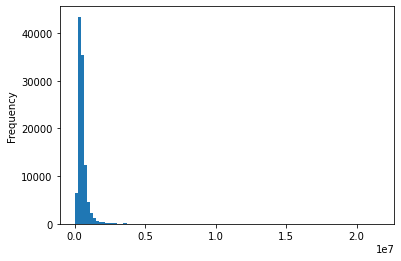

In [30]:
data.price.plot.hist(bins = 100)

In [31]:
data = data[data.price > 20_000]

#### Price per square meter

<AxesSubplot:ylabel='Frequency'>

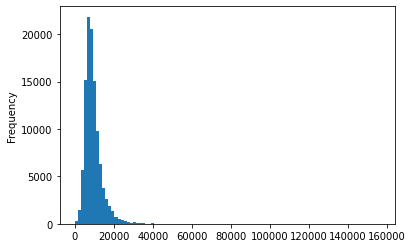

In [32]:
data.price_per_square_meter.plot.hist(bins = 100)

In [33]:
data = data[data.price_per_square_meter > 1_000][data.price_per_square_meter < 70_000]

/var/folders/zv/1r2yhkrn22jbxp293mklny_00000gn/T/ipykernel_35447/4231445625.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[data.price_per_square_meter > 1_000][data.price_per_square_meter < 70_000]


#### Area

<AxesSubplot:ylabel='Frequency'>

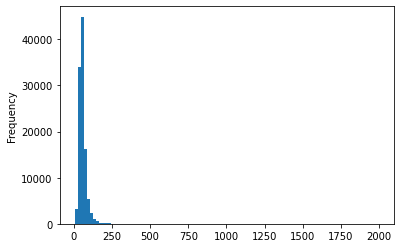

In [34]:
data.area.plot.hist(bins = 100)

In [35]:
data = data[data.area > 10][data.area < 350]

/var/folders/zv/1r2yhkrn22jbxp293mklny_00000gn/T/ipykernel_35447/2038709215.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[data.area > 10][data.area < 350]


#### Rent

<AxesSubplot:ylabel='Frequency'>

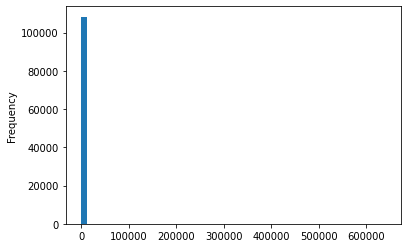

In [37]:
data.rent.plot.hist(bins = 50)

In [38]:
data = data[data.rent < 10000]

#### Number of rooms

<AxesSubplot:ylabel='Frequency'>

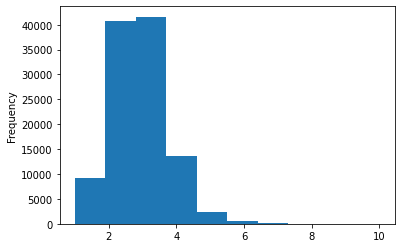

In [39]:
data.number_of_rooms.plot.hist(bins = 10)

#### Floor

<AxesSubplot:ylabel='Frequency'>

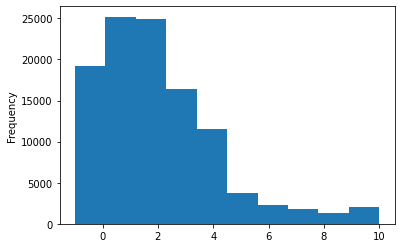

In [40]:
data.floor.plot.hist(bins = 10)

#### Number of floors

<AxesSubplot:ylabel='Frequency'>

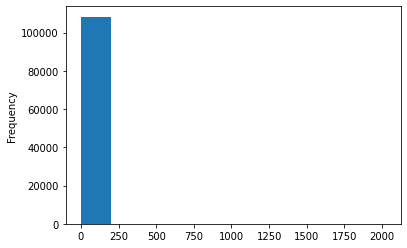

In [41]:
data.number_of_floors.plot.hist(bins = 10)

#### Construction year

<AxesSubplot:ylabel='Frequency'>

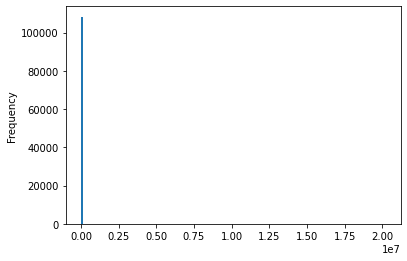

In [43]:
data.construction_year.plot.hist(bins = 150)

In [44]:
data = data[data.construction_year > 1800][data.construction_year < 2030]

/var/folders/zv/1r2yhkrn22jbxp293mklny_00000gn/T/ipykernel_35447/497038564.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[data.construction_year > 1800][data.construction_year < 2030]


#### Time to centre

<AxesSubplot:ylabel='Frequency'>

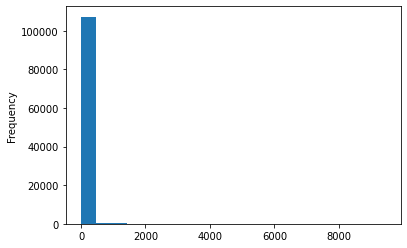

In [46]:
data.time_to_centre.plot.hist(bins = 20)

In [47]:
data = data[data.time_to_centre < 60]

#### Time to the nearest shop

<AxesSubplot:ylabel='Frequency'>

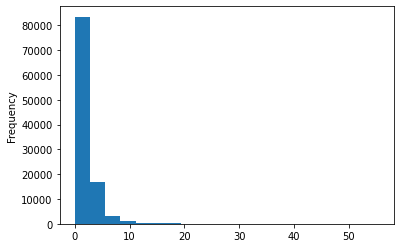

In [49]:
data.time_to_nearest_shop.plot.hist(bins = 20)

In [50]:
data = data[data.time_to_nearest_shop < 60]

#### Time to the nearest shop

<AxesSubplot:ylabel='Frequency'>

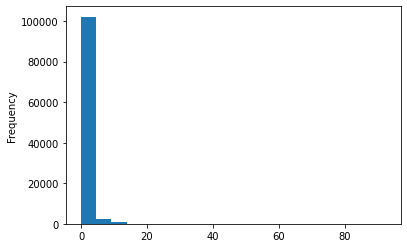

In [52]:
data.time_to_nearest_stop.plot.hist(bins = 20)

In [53]:
data = data[data.time_to_nearest_shop < 60]

In [54]:
data

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,has_balkon,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement,number_of_floors
0,560000.0,9887.0,56.64,"ul. Brylantowa, Dobrzykowice, dolnośląskie",3,2,1,balkon,600.0,garaż/miejsce parkingowe,...,1,0,0,1,1,1,1,0,0,3
1,950000.0,14175.0,67.02,"Warszawa, Praga-Południe, ul. Terespolska",3,2,6,balkon,610.0,garaż/miejsce parkingowe,...,1,0,0,1,1,1,1,0,0,6
2,264900.0,9811.0,27.00,"Katowice, Piotrowice - Ochojec, Ochojec",1,2,5,balkon,460.0,NaN,...,1,0,0,0,0,1,1,0,0,8
3,464000.0,8000.0,58.00,"Sosnowiec, Zagórze",3,2,2,balkon,350.0,garaż/miejsce parkingowe,...,1,0,0,1,0,1,0,0,0,3
4,199900.0,5666.0,35.28,"Sosnowiec, Klimontów",2,2,4,balkon,420.0,NaN,...,1,0,0,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108479,325000.0,5078.0,64.00,"Zabrze, Zaborze, UL. Księdza Pawła Janika 14",3,3,0,balkon,460.0,NaN,...,1,0,0,0,0,0,0,0,1,4
108480,620000.0,10403.0,59.60,"Warszawa, Żoliborz, ul. Marii Dąbrowskiej 11",3,0,6,balkon,770.0,NaN,...,1,0,0,0,1,1,1,0,1,11
108481,63000.0,1024.0,61.50,"Warszawa, Ursynów",3,3,2,NaN,460.0,NaN,...,0,0,0,0,0,0,0,0,0,4
108482,150000.0,5769.0,26.00,"Bełchatów, łódzkie",1,1,2,balkon,460.0,NaN,...,1,0,0,0,0,0,0,0,1,4


#### Population

<AxesSubplot:ylabel='Frequency'>

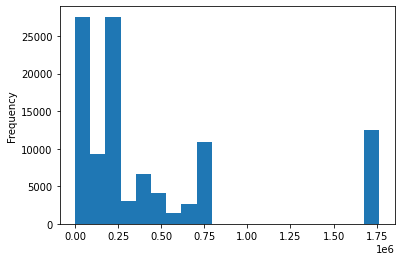

In [55]:
data.population.plot.hist(bins = 20)


In [56]:
data = data[data.population > 0]

In [57]:
data = data.assign(age = 2022 - data.construction_year)

In [58]:
data.columns

Index(['price', 'price_per_square_meter', 'area', 'location',
       'number_of_rooms', 'finishing_standard', 'floor',
       'balcony/garden/terrace', 'rent', 'parking', 'heating', 'market',
       'construction_year', 'building_type', 'windows', 'lift', 'security',
       'furnishings', 'additional_information', 'state', 'locality',
       'population', 'type_of_locality', 'time_to_nearest_shop',
       'time_to_nearest_stop', 'time_to_centre', 'has_balkon', 'has_garden',
       'has_terrace', 'has_parking', 'is_furnished', 'has_lift',
       'has_security_protection', 'is_duplex', 'has_basement',
       'number_of_floors', 'age'],
      dtype='object')

In [59]:
data = data.reset_index(drop = True)

In [60]:
data.head()

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement,number_of_floors,age
0,560000.0,9887.0,56.64,"ul. Brylantowa, Dobrzykowice, dolnośląskie",3,2,1,balkon,600.0,garaż/miejsce parkingowe,...,0,0,1,1,1,1,0,0,3,1
1,950000.0,14175.0,67.02,"Warszawa, Praga-Południe, ul. Terespolska",3,2,6,balkon,610.0,garaż/miejsce parkingowe,...,0,0,1,1,1,1,0,0,6,10
2,264900.0,9811.0,27.00,"Katowice, Piotrowice - Ochojec, Ochojec",1,2,5,balkon,460.0,NaN,...,0,0,0,0,1,1,0,0,8,52
3,464000.0,8000.0,58.00,"Sosnowiec, Zagórze",3,2,2,balkon,350.0,garaż/miejsce parkingowe,...,0,0,1,0,1,0,0,0,3,2
4,199900.0,5666.0,35.28,"Sosnowiec, Klimontów",2,2,4,balkon,420.0,NaN,...,0,0,0,0,0,0,0,1,4,4


In [61]:
columns_to_drop = [
    'balcony/garden/terrace',
    'parking',
    'lift',
    'additional_information',
    'security',
    'location',
    'furnishings',
    'construction_year'
]
data = data.drop(columns=columns_to_drop)


In [62]:
data.describe()

,price,price_per_square_meter,area,number_of_rooms,finishing_standard,floor,rent,heating,market,construction_year,...,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement,number_of_floors,age
count,1.052760e+05,105276.000000,105276.000000,105276.000000,105276.000000,105276.000000,105276.000000,105276.000000,105276.000000,105276.000000,...,105276.000000,105276.000000,105276.000000,105276.000000,105276.000000,105276.000000,105276.000000,105276.000000,105276.000000,105276.000000
mean,5.525283e+05,9470.132803,58.452951,2.644107,1.785953,2.277860,474.036318,4.779171,0.736398,2005.641105,...,0.111155,0.117073,0.483975,0.245317,0.409087,0.485125,0.026568,0.367909,4.683005,16.358895
std,4.687601e+05,4446.375613,25.246630,0.948990,0.920103,2.007873,165.980059,2.067795,0.570449,27.067787,...,0.314326,0.321509,0.499746,0.430277,0.491668,0.499781,0.160819,0.482239,10.932389,27.067787
min,2.700000e+04,1008.000000,10.250000,1.000000,0.000000,-1.000000,0.010000,0.000000,0.000000,1810.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-3.000000
25%,3.400000e+05,6650.000000,43.160000,2.000000,1.000000,1.000000,460.000000,4.000000,0.000000,2002.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,4.584060e+05,8577.000000,54.000000,3.000000,2.000000,2.000000,460.000000,4.000000,1.000000,2018.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000
75%,6.190030e+05,11176.000000,66.610000,3.000000,3.000000,3.000000,460.000000,7.000000,1.000000,2022.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,5.000000,20.000000
max,1.400000e+07,68807.000000,349.000000,10.000000,3.000000,10.000000,9000.000000,7.000000,2.000000,2025.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2022.000000,212.000000


In [63]:
data.dtypes

price                      float64
price_per_square_meter     float64
area                       float64
number_of_rooms              Int64
finishing_standard           int64
floor                        Int64
rent                       float64
heating                      int64
market                       int64
construction_year            Int64
building_type                int64
windows                      int64
state                        int64
locality                     int64
population                 float64
type_of_locality             int64
time_to_nearest_shop       float64
time_to_nearest_stop       float64
time_to_centre             float64
has_balkon                   int64
has_garden                   int64
has_terrace                  int64
has_parking                  int64
is_furnished                 int64
has_lift                     int64
has_security_protection      int64
is_duplex                    int64
has_basement                 int64
number_of_floors    

In [64]:
data.isna().sum()

price                      0
price_per_square_meter     0
area                       0
number_of_rooms            0
finishing_standard         0
floor                      0
rent                       0
heating                    0
market                     0
construction_year          0
building_type              0
windows                    0
state                      0
locality                   0
population                 0
type_of_locality           0
time_to_nearest_shop       0
time_to_nearest_stop       0
time_to_centre             0
has_balkon                 0
has_garden                 0
has_terrace                0
has_parking                0
is_furnished               0
has_lift                   0
has_security_protection    0
is_duplex                  0
has_basement               0
number_of_floors           0
age                        0
dtype: int64

In [65]:
data.to_csv('./preprocessed_dataset_flats.csv')